# Worksheet 7: Model Evaluation and Model Selection

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. List model metrics that are suitable for evaluation of a statistical model developed to make inference about the data-generating mechanism (e.g., $R^2$, $\text{AIC}$, Likelihood ratio test/$F$-test), their strengths and limitations, as well as how they are calculated.
2. Write a computer script to calculate these model metrics. Interpret and communicate the results from that computer script.
3. Explain the algorithms for the following variable selection methods:

    - $F$-test to compare nested models.
    - Forward selection.
    - Backward selection.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(latex2exp)
source("tests_worksheet_07.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




# PART I: Model Evaluation

## Inference vs Predition

To assess or select a model there is a more essential question to answer: 
    
### <font color=red>  What is your goal??
    
The evaluation metrics are different depending on the goal of the analysis
    
> the estimation methodologies can also differ although we cover only LS in the course
    
- **Inference**: your primary goal is to understand the relation between a response variable $Y$ and a set of input variables $X_1, \ldots, X_p$ 
    
    > you estimate the LR using a sample to understand how variables are associated (in the population)
    
    > you use methods to draw conclusions about the population from the results obtained in the sample (inference)
    
- **Prediction**: your primary goal is to make predictions about the response $Y$, and you are not so concerned about how you got those predictions
    
    > you estimate the LR using a sample to make predictions of the response for *new* units (houses, subjects, counties, etc) from the population
    
    
**Examples of inference problems**: 
    
- A real estate agent wants to identify factors that are related to the assessed values of homes (e.g., size of houses, age, amenities, etc) 
    
    
- Biologists want to verify empirically the central dogma of biology that relates mRNA to protein values 
    
    
**Examples of prediction problems**: 
    

- A real estate agent is interested in determining if a house is under- or over-valued given its characteristics (prediction problem)


- Biologists want to use mRNA data to predict protein values
    
**In this worksheet you will learn different methods to evaluate and select appropriate models depending on the goal of your study.**

## Case Study: protein vs mRNA

In this section we will introduce a new case study to learn how to examine the goodness of the fitted model and choose among different nested models. The data and some of the discussions related to this case were published in Nature (see citations below).

In 2014, a research group claimed to find a "predictive model", which can be used to predict protein from mRNA expression!! 

> Wilhelm, M. et al. Mass-spectrometry-based draft of the human proteome. Nature 509, 582–587 (2014)

Although their hypotheses were funded in the Central Dogma of Biology, most experimental results have shown very low correlation values between protein and mRNA values. 

Further examination of their analysis has shwon that their data do not support their claims:

> Paper from my research group: Fortelny N, Overall CM, Pavlidis P, Freue GVC. Can we predict protein from mRNA levels? Nature. 2017 Jul 26;547(7664):E19-E20. doi: 10.1038/nature22293.

We'll use data from this group submitted to the Journal to (re)analyse their data and evalute different models using concepts learned in this course.

### Relation between mRNA and protein levels

The picture illustrates what is known as the Central Dogma of Biology

![](https://github.com/UBC-STAT/stat-301/blob/master/materials/worksheet_07/img/prot_gene.png?raw=true)

Let's start by taking a glance at the data.

> Protein and mRNA values were measured for 6104 genes on 12 different tissues. 

Note that these are 2 different dataset!! 

> However, many proteins were not detected by the technology used due to values below limits of detection and the protein dataset contains many missing values!! 

For simplicity, we will use **a set of 1392 genes** that were measured in **all 12 tissues** and thus contain complete data on both protein and mRNA sets. 

You can find in Canvas the script that was used to wrangle the original datases from the Journal.

*Run the cell below before continuing to read in the data.* 

In [2]:
# Read and take a look at the data.
dat_bio <- read.csv("data/nature_dat.csv", row.names = 1, stringsAsFactors=TRUE)
str(dat_bio)
head(dat_bio,3)
tail(dat_bio,3)

'data.frame':	16704 obs. of  4 variables:
 $ gene  : Factor w/ 1392 levels "ENSG00000000419",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ tissue: Factor w/ 12 levels "adrenal.gland",..: 12 12 12 12 12 12 12 12 12 12 ...
 $ prot  : num  9.97e-06 3.63e-05 1.69e-05 6.75e-05 5.55e-05 ...
 $ mrna  : num  3.44e-05 1.42e-05 1.92e-05 3.64e-05 3.89e-05 ...


,gene,tissue,prot,mrna
,<fct>,<fct>,<dbl>,<dbl>
1,ENSG00000000419,uterus,9.966484e-06,3.44e-05
3,ENSG00000000971,uterus,3.633516e-05,1.42e-05
5,ENSG00000001084,uterus,1.693588e-05,1.92e-05


,gene,tissue,prot,mrna
,<fct>,<fct>,<dbl>,<dbl>
57882,ENSG00000262246,esophagus,3.337902e-05,6.90e-06
57886,ENSG00000269190,esophagus,3.703505e-06,7.80e-06
57888,ENSG00000272325,esophagus,2.574201e-05,1.35e-05


We can think that we have **1392 datasets**, one for each gene!

> each dataset contains **12 observations**, one per tissue, and 2 variables, `protein` and `mrna`, along with an accession number for the gene (`gene`, an ID for each gene) and the name of the tissue (`tissue`, that works as an ID for each observation).

*Run the cell below to get the data for gene ENSG00000085733.* 

In [3]:
dat_g1 <- dat_bio  %>% subset(gene == "ENSG00000085733") 
dat_g1

,gene,tissue,prot,mrna
,<fct>,<fct>,<dbl>,<dbl>
585,ENSG00000085733,uterus,1.648298e-06,0.0001278
5409,ENSG00000085733,kidney,1.349573e-05,0.0000673
10233,ENSG00000085733,testis,4.069264e-05,0.0000862
15057,ENSG00000085733,pancreas,9.279162e-06,0.0000358
19881,ENSG00000085733,stomach,2.254923e-05,0.0001167
24705,ENSG00000085733,prostate,6.259907e-06,0.0000931
29529,ENSG00000085733,ovary,8.225857e-05,0.0001345
34353,ENSG00000085733,thyroid.gland,5.948111e-07,0.0000885
39177,ENSG00000085733,adrenal.gland,2.461557e-05,0.0001172


## 1.Estimation and Inference

In the paper, the authors used a linear regression to estimate the relation between protein and mRNA levels *per gene*, and used that model to predict protein levels *per gene*.

> it will be important at a later phase of the analysis to note that models are *gene-specific*

**Gene-specific models**: for each gene they estimated the following model (for simplicity we do not use a subscript $g$)  

$$\text{prot}_{t} = \beta_1 \; \times \text{mrna}_{t} + \varepsilon$$ 

where $\hat{\beta}_1 = median_t(\text{mrna}_{t}/\text{prot}_{t})$

> $prot_{t}$ and $mrna_{t}$ are the protein and mRNA levels of a gene $g$ in tissue $t$, respectively

<font color="blue"> **Note that these models do not contain an intercept! and they were not estimated by LS.**</font> 
    
While in general different models and estimation methods can be used to analyze the same data, it is important to evaluate the results according to the assumptions and the methodology used. 
    
> The evaluation and interpretation of the results in the paper were not appropriate
    
*We will start by (re)anlayzing the data using a SLR and LS estimation*

**Gene-specific SLR**: for each gene we will use LS to estimate the following SLR (for simplicity we do not use a subscript $g$)  

$$prot_{t} = \beta_0 +\beta_1 \; \times mrna_{t} + \varepsilon$$ 

where $\hat{\beta}_g$ is estimated by LS

> using `lm()` and `group_by(gene)`

### 1.1 Visualization and Estimation:

Let's focus on the proposed model for one gene (geneID: ENSG00000085733)

`geom_smooth()` using formula 'y ~ x'



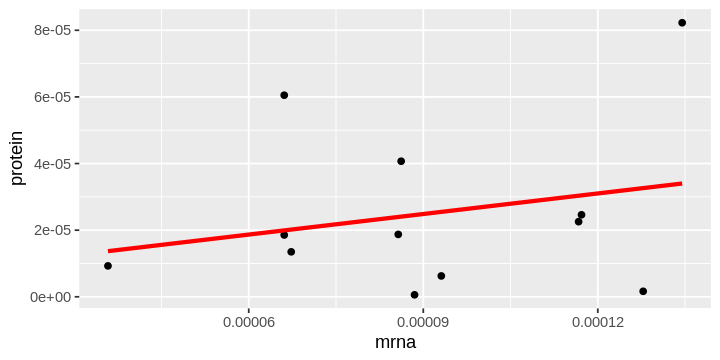

In [4]:
options(repr.plot.width = 6, repr.plot.height = 3) # Adjust these numbers so the plot looks good in your desktop.

plot_g1 <- dat_g1 %>% ggplot(aes(mrna,prot)) +
                ylab("protein")+
                geom_point() + geom_smooth(aes(mrna,prot), method = lm, se = FALSE, size = 1.2, color="red")

plot_g1

We can get results from the LS estimates and corresponding tests for this particular gene:

> remember that this is *only 1* gene in the dataset but there are 1391 more genes!!

In [6]:
slr_g1 <- lm(prot ~ mrna,data=dat_g1)
tidy(slr_g1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.327928e-06,2.446664e-05,0.2586349,0.8011625
mrna,2.057447e-01,2.583776e-01,0.7962945,0.4443536


### 1.2 Predicted values and Residuals

#### The predicted values:

The blue dot, <font color="blue"> $\hat{Y}$ </font> in the line, is the *predicted* protein level for a given amount of mRNA in this gene, predicted by our estimated model! 

> In `R` output all predicted values are stored in the column `.fitted`. 

$$\hat{y}_i = \hat{\beta}_0 +  \hat{\beta}_1 * x_{i}$$

In our case:

$$ \hat{\text{prot}}_{t} = 6.33e-06 + 0.02 * \text{mrna}_{t}$$

> we put a "hat" on $y$ to indicate that it's a predicted value using the estimated regression 

> NOTE: there's no error term in the predicted model!

The predictions $\hat{Y}_i$ are random variables since they are functions of the estimators of the coefficients. 

> we can estimate their standard error and CI!!

But once we get a value based on an observed sample, they become a non-random real number. *Deja vu??*

#### The residuals:

The *residual* is the difference between the predicted and the observed value of the response

> In `R` output all predicted values are stored in the column `.resid`. 


$$ \text{res}_i = y_{i}-\hat{y}_{i}$$

In our case:

$$ \text{res}_t=\text{prot}_{t}-\hat{\text{prot}}_{t}$$

> **Note**: $\varepsilon_i \ne \text{res}_i$

The residuals are the errors of the prediction and estimates of the error terms in the regression.

In [ ]:
dat_g1 <- dat_g1 %>% do(augment(slr_g1))
dat_g1

In [ ]:
#one particular point in the data to illustrate new concepts
dat_g1_0 <- dat_g1[10,]

plot_g1 <- dat_g1 %>% 
    ggplot(aes(mrna,prot)) +
    geom_point() + 
    geom_smooth(aes(mrna,prot), method = lm, se = FALSE, size = 1.2, color="red")+
    geom_point(aes(x = dat_g1_0$mrna, y = dat_g1_0$.fitted), 
               color="blue", size=3)+
    geom_text(aes(x=dat_g1_0$mrna + 3.7*10^(-6),y=dat_g1_0$.fitted - 5*10^(-6),
                  label=TeX(r"($\hat{y}_i$)", output = "character")), 
                  color="blue", size=5,parse = TRUE)+
    geom_text(aes(x=dat_g1_0$mrna + 2.5*10^(-6),y=dat_g1_0$prot+ 5*10^(-6),
                  label=TeX(r"($y_i$)", output = "character")), size=5,parse = TRUE)+
    geom_segment(x=dat_g1_0$mrna, y=dat_g1_0$.fitted,
                 xend=dat_g1_0$mrna,yend=dat_g1_0$prot, 
                 linetype="dotted",color="brown")+
    geom_text(aes(x=dat_g1_0$mrna + 3.7*10^(-6),y=dat_g1_0$prot - 10^(-5),
                  label=TeX(r"(res$_i$)", output = "character")), 
                  color="brown", size=5,parse = TRUE)+
    ylab("protein")
    
plot_g1

### 1.3 Goodness of fit: is our model better than "nothing"?

We are now ready to evaluate the fit of our model to the observed data.

Without any additional information, the best predictor of the response $Y$ is $E[Y]$ which we can estimate with the sample mean of $Y$ ...

> "nothing" means no explanatory variables, intercept-only model

<font color="blue"> so why do we need a LR?? </font>

**Because, given the (additional) information** in $\mathbf{X}$, the "best" predictor is $E[Y|\mathbf{X}]$ which we can model as a LR to estimate it!! 

> "best" according to a criteria: minimizes the mean square error!

> Note that there are different ways of estimating this conditional expectation!

So, here is an important question: 

> Is our linear regression better than just using $E[Y]$ to predict??

**Statistically, we want to compare our prediction <font color="blue"> $\hat{Y}$ </font> (the best estimate of $E[Y|\mathbf{X}]$) with <font color="red"> $\bar{Y}$ </font> (the best estimate of $E[Y]$)** (note that font colors match the plots below).

Let's represent the errors of these 2 predictors with squares of their errors since in LS we want to minimize the sum of the squares of these errors. 

**Visually**:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Coefficient_of_Determination.svg/800px-Coefficient_of_Determination.svg.png)

**Mathematically**:

#### 1.3.1 Sum of squares decomposition

<font color="blue"> If parameters are estimated using LS and the LR has an intercept</font>, it can be proved that 

$$\sum_{i=1}^n(y_i-\bar{y})^2 = \sum_{i=1}^n(\hat{y}_i-\bar{y})^2 + \sum_{i=1}^n(y_i - \hat{y}_i)^2$$

Each of these sums carry important information to evaluate our analysis:

**Total Sum of Squares**: $TSS=\sum_{i=1}^n(y_i-\bar{y})^2$

- this is the sum of the squares of the residuals from the intercept-only (no explanatory variables) model

- the squares of these residuals are represented with red squares in the plot above

- when properly scaled, it is the sample variance of $Y$ which *estimates* the population variance of $Y$


**Explained Sum of Squares**: $ESS=\sum_{i=1}^n(\hat{y}_i-\bar{y})^2$

- $\hat{y}_i$ predicts $y_i$ using the LR, while $\bar{y}$ predicts $y_i$ without a model. If our model is better than nothing, this should be large!!

- it measures how much it is *explained* by the additional information given by the LR


**Residual Sum of Squares**: $RSS=\sum_{i=1}^n(y_i - \hat{y}_i)^2$

- this is the sum of the squares of the residuals from the *fitted* LR with explanatory variables

- the squares of these residuals are represented with blue squares in the plot above

- our estimated parameters minimize these errors, this should be small!!

#### 1.3.2 The coefficient of determination

If our model provides a good fit, we expect the TSS (residuals from the empty model, in red) to be much larger than the RSS (residuals from the fitted LR with explanatory variables, in blue)!! 

Using the decomposition above and dividing by TSS: 

$$1=\frac{\text{ESS}}{\text{TSS}} + \frac{\text{RSS}}{\text{TSS}}$$


**The Coefficient of determination** was first defined as:

$$R^2=1 - \frac{\text{RSS}}{\text{TSS}}$$

*For a LR with an intercept and estimated by LS* it is equivalent to 

$$R^2=\frac{\text{ESS}}{\text{TSS}}$$ 

#### Interpretations 

For a LR with an intercept and estimated by LS, the coefficient of determination:

- measures the gain in predicting the response using the LR instead of the sample mean, relative to the total variation in the response. 


- is also interpreted as the proportion of variance of the response (TSS) explained by the model (ESS)


- is between 0 and 1 since we expect TSS to be much larger than RSS (thus their ratio is smaller than 1)

*Don't worry, R computes this statistic for you!!*

In [ ]:
glance(slr_g1)

(my_Rsq <- 1-sum(dat_g1$.resid^2)/(sd(dat_g1$prot)^2*(nrow(dat_g1)-1)))


The $R^2$ compares $Y$ vs $\hat{Y}$ using the RSS but *relative to* the TSS 

<font color="blue"> **In a SLR, the coefficient of determination equals the square of the correlation coefficient** </font>

> you probably noticed this in the SLR: $r^2=R^2$

**Note**: this is not true for any type of estimation. In particular, it is not true for the estimation method suggested in the Nature's paper or their models since they do not have an intercept!

<font color="blue"> **In LR, the coefficient of determination equals the square of the coefficient of multiple correlation** </font>


> in fact, the coefficient of determination was first introduced this way in 1921!


> the $R^2 = cor(Y, \hat{Y})^2$, if $\hat{Y}$ is a predition obtained from a LR with an intercept estimated by LS

**Note**: in the paper the authors computed this measure but *not* per each gene, which flawed their conclusions.

#### Scope and limitations of the coefficient of determination

The $R^2$ is computed based on *in-sample* observations and it does not provide a sense of how good is our model in predicting *out-of-sample* cases (aka test set)!!

Note that $R^2$ computed as $R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$ ranges between 0 and 1 *if* the LR model has an intercept and is estimated by LS!! 

> otherwise, this definition can result in negative values!! (see discussion in Wooldridge)

> A negative $R^2$ indicates that the sample mean is a better predictor than the estimated linear regression. We'll come to this point later.

*Let's compute the $R^2$ for all the genes in the dataset*

**Question 1.0**
<br>{points: 1}

In this problem you will: 

- fit 1392 SLR, one for each gene in the dataset using `lm()` and `group_by()`

- use the function `augment()` to compute residuals from each fitted SLRs

- compute the RSS and the TSS for each gene and estimated SLR

- use the RSS and the TSS to compute the $R^2$ for each gene and estimated SLR

Collect all these quantities in an object called `data_ss`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# n_tissues = ...

#dat_ss <- dat_bio %>%  
#  group_by(...) %>%
#  do(augment(...(prot ~ ..., data = .)))   %>% 
#  summarize(RSS= sum(...),TSS=...(...)^2*(n_tissues - 1),
#           myR2 = 1- .../...)

# head(dat_ss,3)

### BEGIN SOLUTION
n_tissues = 12

dat_ss <- dat_bio %>%  
  group_by(gene) %>%
  do(augment(lm(prot ~ mrna, data = .)))   %>% 
  summarize(RSS= sum(.resid^2),TSS=sd(prot)^2*(n_tissues - 1),
           myR2 = 1- RSS/TSS)

head(dat_ss,3)
### END SOLUTION

In [ ]:
test_1.0()

**Question 1.1**
<br>{points: 1}

In this problem you will compute the $R^2$ for each gene and estimated SLR using the function `glance()`

- select the columns `gene` and `r.squared` and store them in an object called `data_r2`

- extend `data_r2` by joining it `data_ss` to compare your calculation of the $R^2$ with that given by `glance()`


*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
#dat_glance <- dat_slr  %>% 
#  group_by(...)  %>% 
#  do(glance(...(... ~ ..., data = .))) 

#dat_r2 <- dat_glance %>% 
#  select(..., ...)

#dat_r2 <- dat_ss  %>%  full_join(dat_r2, by = c("gene")) 

#tail(dat_r2,3)

### BEGIN SOLUTION
dat_glance <- dat_slr  %>% 
  group_by(gene)  %>% 
  do(glance(lm(prot ~ mrna, data = .))) 

dat_r2 <- dat_glance  %>% 
  select(gene, r.squared)

dat_r2 <- dat_ss  %>%  full_join(dat_r2, by = c("gene")) 

tail(dat_r2,3)
### END SOLUTION

In [ ]:
test_1.1()

#### Visualization of results 

We have computed 1392 coefficients of determination, one for each *gene-specific* fitted model. Let's visualize the results using a histogram of the coefficients of determination

In [ ]:
hist_ls_r2 <- dat_r2  %>% 
  ggplot(aes(x=r.squared)) + 
  geom_histogram(color="navy", bins=20) + 
  geom_vline(xintercept=median(dat_r2$r.squared, na.rm=T),color="red")+
  labs(
    title = "Rsq of gene-specific LS models",
    x = "Rsq",
    y = "Count")+
  xlim(0, 1)

hist_ls_r2

**Question 1.2**
<br>{points: 1}

In the following claims, a "gene-specific model" refers to a SLR using `mRNA` as an input variable and estimated by LS for each gene.

Select all the claims that are true based on the $R^2$ computed for each gene.

**A.** These results suggest that the quality of the proposed models vary greatly across genes. For some genes, a gene-specific model explains more than 80% of the observed variation in protein abundance. However, for half of the genes it explains less than 15% of the observed variation in protein levels.

**B.** For the majority of the genes, a gene-specific model fits the data well. 

**C.** With the suggested gene-specific models, it now becomes possible to predict protein abundance in any given tissue with good accuracy from the measured mRNA for any gene.  

**D.** For gene ENSG00000262246, the gene-specific model explains approximately 87% of the observed variation in protein abundance, making `mRNA` statistically significant.

*Assign your answer to an object called `answer1.2`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [ ]:
# answer1.2 <- 

### BEGIN SOLUTION
answer1.2 <- "A"
### END SOLUTION

In [ ]:
test_1.2()

#### Claim from the paper

Using the median ratio of protein to mRNA levels per gene as a proxy for translation rates, our data show that [...] ***it now becomes possible to predict protein abundance in any given tissue with good accuracy from the measured mRNA abundance***

<font color="blue"> Hmmmm .... how??? is the median ratio a much better estimate of the regression coefficients?? </font>

*We'll come back for this later ....*

#### 1.3.3 Model Evaluation via Adjusted $R^2$

A drawback of the $R^2$ is that it increases as more input variables are added to teh model, *regardless of the relevance of the input variables added* since the $\text{RSS} = \sum_{i = 1}^n(y_i - \hat{y}_i)^2$ as more input variables are included in the model. 

To overcome this issue with $R^2$, we can obtain an **adjusted $R^2$** as follows:

$$ \text{adjusted } R^2 = 1- \frac{\text{RSS}/(n - p)}{\text{TSS}/(n - 1)},$$

where 

- $p$ is the number of regression parameters of the model, including $\beta_0$.
- $n$ is our sample size to train the model.

This adjusted coefficient of determination penalizes $\text{RSS}$ with $n - p$. Hence, even if the $\text{RSS}$ decreases, we divide it by $n - p$ to compensate for the model's size.

#### 1.3.4 Other evaluation metrics

Other related metrics used to evaluate LR which measure how far $Y$ is from $\hat{Y}$ are:


- **Residuals Standard Error**: RSE = $\sqrt{\frac{1}{n-p} \text{RSS}}$

> called `sigma` in `glance()` output

> estimates the standard deviation of the error term $\varepsilon$ (the RSS is divided by the appropriate degrees of freedom to give a "good" estimate of $\sigma = \sqrt{Var(\varepsilon)}$)

> needed to estimate the standard errors of $\hat{\beta}_j$ in classical theory! (for inference)

> a measure based on *training* data to evaluate the fit of the model (for inference)

> gives an idea of the size of the *irreducible* error, very similar to the RSS, small is good


- **Mean Squared Error**: MSE = $\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$

> *Training MSE*: if we use the original sample $y_1, \ldots, y_n$ and their predicted values (formula above). It can be easily obtained from `.resid` column in `augment()` output 

### 1.4 Selection of nested models: the *F*-test

Are the $R^2$ or its adjusted version useful?? 

- For some genes, the $R^2$ is around 50%, is this value large??

The $R^2$ can be used to compare the size of the residuals of the fitted model with those of an empty model. However, we can't use it to *test* any hypothesis to answer this question since its sampling distribution is unknown.


Alternatively, the **$F$-test** can be used to compare *nested* models. 

> what do we mean by *nested models*?

> <font color=blue> nested </font>: the full model contains all the variables from the reduced model together with $k$ additional input variables

**Case 1:**
Let's compare a SLR with an intercept only model:

- model reduced: $Y_i=\beta_0 + \varepsilon_i$ 

    > LR with no input variables


- model full:  $Y_i=\beta_0 + \beta_1 X_{i} + \varepsilon_i$ 

    > SLR with 1 additional input variable


#### <font color=red> Is the full model significantly different from the reduced model? </font>

To compare and test nested models we need an **$F$-test**

> the function `anova()` can be used to compute this test

> `glance()` also includes this statistic and its corresponding p-value

In [ ]:
lm_red <- lm(prot~1, dat_g1)

lm_full <- lm(prot~ mrna, dat_g1)

anova(lm_red,lm_full)

Note that in this simple case, the only difference between the reduced and the full model is the term with $\beta_1$

> we are testing if $\beta_1$ is different from zero!! $H_0: \beta_1 = 0$

Same as before!! 

> Note the $p$-values are the same. This is not a coincidence! 

When we test only one parameter: $t^2 = F$

In [ ]:
anova(lm_red,lm_full)
glance(slr_g1)  %>% select(statistic, p.value)
tidy(slr_g1)

For this gene, the full model is not statistically different from the reduced (intercept only) model at a significance level of 5%.

> for this gene, the full model, including `mrna` does not fit the data significantly better than then intercept only model! 

**For this gene, there is not statistical evidence that mRNA is associated with protein levels**

As before, we can look at the results of *all* genes

In [ ]:
hist_ls_F <- dat_glance  %>% 
  ggplot(aes(x=p.value)) + 
  geom_histogram(color="navy", bins=20) + 
  geom_vline(xintercept=median(dat_glance$p.value, na.rm=T),color="red")+
  geom_vline(xintercept=0.05,linetype = 2, color="green")+
  labs(
    title = "F-test of gene-specific LS models",
    x = "p.value",
    y = "Count")+
  xlim(0, 1)

hist_ls_F

#### Claim from the paper

Using the median ratio of protein to mRNA levels per gene as a proxy for translation rates, our data show that [...] ***it now becomes possible to predict protein abundance in any given tissue with good accuracy from the measured mRNA abundance***

**In our analysis, for most genes, the model with `mrna` is not significanly better, at 5% significance, than the empty model.**

<font color="blue"> Hmmmm .... is the median ratio a much better estimate of the regression coefficients?? </font>

*We'll come back for this later ....*

#### Back to the F-test:

In the previous case, the $F$-test was used in a very simple case, mathematically equivalent to a (squared) $t$-test.

However, the $F$-test can be generalized to compare any pair of *nested* models.

**Case 2:**

- model reduced: $Y_i=\beta_0 + \varepsilon_i$ 

    > LR with no input variables


- model full:  $Y_i=\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \varepsilon_i$ 

    > LR with 2 additional input variables
    
    
#### <font color=red> Is the full model significantly different from the reduced model? </font>

Note that now the full model has 2 extra terms!!

> $H_0: \beta_1 = 0 \text{ and }  \beta_2 = 0$

We are *simulataneously* testing if *both parameters* are zero!!

**Case 3: general**

- model reduced: $Y_i=\beta_0 + \beta_1 X_{i1} + \ldots + \beta_q X_{iq} + \varepsilon_i$ 

    > LR with $q+1$ variables


- model full:  $Y_i=\beta_0 + \beta_1 X_{i1} +  \ldots + \beta_q X_{iq} + \ldots +  \beta_s X_{is} + \varepsilon_i$ 

    > LR with $p=s+1$ variables, $k = s - q$ additional explanatory variables
    
    
#### <font color=red> Is the full model significantly different from the reduced model? </font>

Note that in this simple case, we are testing if $\beta_1$ is different from zero!!

> $H_0: \beta_{q+1} = 0 \text{ and }  \beta_{q+2} = 0 \text{ and } \ldots  \beta_{s} = 0$

We are *simulataneously* testing if *k parameters* are zero!!

It can be challenging to write the model and the null hypothesis mathematically. 

However, in any analysis, you should be able identify both the reduced and the full models being compared and tested. 

**(For fun) the formula of the F-statistic is given by:** 

$$F = \frac{(RSS_{reduced}-RSS_{full})/k}{RSS_{full}/(n-p)} \sim \mathcal{F}_{k, n-p}$$

- $RSS_{reduced}$ is the **RSS** of the reduced model 


- $RSS_{full}$ is the **RSS** of the full model 


- $k$ is the number of parameters tested (difference between models)


- $p$ is the number of parameters of the full model ($s+1$)

For LS estimation, if the conditional distribution of the error terms $\varepsilon_i$ is normal, under $H_0$:

$$F \sim \mathcal{F}_{k, n - p}$$ 

i.e., the $F$-statistic has an $\mathcal{F}$ distribution with $k$ degrees of freedom in the numerator and $n - p$ degrees of freedom in the denominator. Otherwise, this is still approximately true by results of the CLT for large samples.

> the $F$ and the $R^2$ both depend on the RSS and the TSS so there is a formula that relates them!! however, the former has a known (or approximately known) sampling distribution (under certain assumptions) so we can use it to make probabilistic statements

*Don't worry, R computes this statistic for you!!*

To illustrate other applications of the $F$-test, let's consider a subset with 3 randomly selected genes. 

We will use this (sub)dataset to analyze the relation between `mrna` and `prot`, *and* `gene` as a variable in the model!!

In [ ]:
set.seed(561)
dat_3genes <- dat_bio  %>%  
         subset(gene %in% sample(gene,3)) 

res_per_g <- dat_3genes %>%
         group_by(gene) %>%
         do(glance(lm(prot ~ mrna, data = .)))  %>% 
         select(gene, r.squared, statistic, p.value)

res_per_g

#### LR with 1 categorical and 1 continuous, without interaction (additive)

This model assumes that when mRNA changes the change in protein levels is the same for all 3 genes but allows different predictions for different genes:

$$\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \beta_2 \text{G2}_{t} + \beta_3 \text{G3}_{t} + \varepsilon_t$$

> the subscript $t$ indicates the tissue where the gene was measured

#### Recall ....


The variables $G2$ and $G3$ are dummy variables that take only 2 values, 0 and 1

> $G2 = 1$ for gene ENSG00000143553, and it's $0$ otherwise 

> $G3 = 1$ for gene ENSG00000168497, and it's $0$ otherwise


> as before, we use 2 dummy variables to model 3 levels of a categorical variable

Let's take a closer look at our model:

- for gene ENSG00000085733, $G2=0$ and $G3=0$ : then 

$$\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \varepsilon_t$$

> just replace the dummy variables with 0, respectively, in the equation above

> this is just a SLR with intercept $\beta_0$ and slope $\beta_1$ to model the relation between `protein` and `mrna`!!

- for gene ENSG00000143553, $G2=1$ and $G3=0$: then 

$$\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \beta_2  + \varepsilon_t$$ 

> just replace the dummies with 1 and 0, respectively, in the equation above

> this is just a SLR with *the same* slope $\beta_1$ to model the relation between `prot` and `mrna`!!

> but note that in this case the intercept is *different*: $\beta_0 + \beta_2$

- for gene ENSG00000168497, $G2=0$ and $G3=1$: then 

$$\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \beta_3  + \varepsilon_t$$ 

> just replace the dummies with 0 and 1, respectively, in the equation above

> this is just a SLR with *the same* slope $\beta_1$ to model the relation between `prot` and `mrna`!!

> but note that in this case the intercept is *different*: $\beta_0 + \beta_3$

**Question 1.3**
<br>{points: 1}

Using the data from the 3 selected genes `data_3genes`, fit the additive model outlined above. Store the results in an object called `mlr_3genes_add`.

Use `tidy` to obtain a table with results from the LS estimation and inference. 

In [ ]:
#mlr_3genes_add <- ...(...~ ..., data = dat_3genes)
#mlr_3genes_add_res <- tidy(mlr_3genes_add)
#mlr_3genes_add_res


### BEGIN SOLUTION
mlr_3genes_add <- lm(prot~ gene + mrna,dat_3genes)
mlr_3genes_add_res <- tidy(mlr_3genes_add)
mlr_3genes_add_res
### END SOLUTION

In [ ]:
test_1.3()

#### Visualizing the data and fitted model

In [ ]:
#Define a grid to extend the estimated LR
newdat = expand.grid(mrna = seq(min(dat_3genes$mrna), max(dat_3genes$mrna), by = 1e-06),
                     gene = unique(dat_3genes$gene) )
newdat$pred_add = predict(mlr_3genes_add, newdata = newdat)

plot_add <- ggplot(dat_3genes, aes(x = mrna, y = prot, color = gene)) +
     geom_point(size=.5) +     
     geom_line(data = newdat, aes(y = pred_add), size = 0.5)+
     labs(title = 'Additive Model', x = "mRNA", y = "Protein") + 
     theme(plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
        axis.title = element_text(face = "bold", size = 12))

plot_add

#### LR with 1 categorical and 1 continuous, *plus* interactions: 

Let's now consider a model that assumes that when mRNA changes the change in protein levels is different for each genes. Each gene should have its own translation rate!!

> isn't this the same as the *gene-specific* models??

> Wilhelm et al.: "translation rate is a fundamental, encoded (constant) *characteristic of a transcript [gene]*"


$$\text{prot}_t = \beta_0 + \beta_1 \text{mrna}_{t} + \beta_2 G2_{t}  + \beta_3 G3_{t}  + \beta_4 G2_{t} * \text{mrna}_{t} + \beta_5 G3_{t} * \text{mrna}_{t} +\varepsilon_t$$


> mathematically, we multiply variables

> Recall: 6 parameters related to 3 intercepts and 3 slopes

Using the data from the 3 selected genes `data_3genes`, we will now fit the model with interaction terms outlined above. 

We will store the results in an object called `mlr_3genes_int` and use `tidy` to obtain a table with results from the LS estimation and inference. 

In [ ]:
mlr_3genes_int <- lm(prot ~ gene * mrna, dat_3genes)
tidy(mlr_3genes_int)

In [ ]:
newdat = expand.grid(mrna = seq(min(dat_3genes$mrna), max(dat_3genes$mrna), by = 1e-06),
                     gene = unique(dat_3genes$gene) )
newdat$pred_int = predict(mlr_3genes_int, newdata = newdat)

plot_int <- ggplot(dat_3genes, aes(x = mrna, y = prot, color = gene)) +
     geom_point(size=.5) +     
     geom_line(data = newdat, aes(y = pred_int), size = 0.5)+
     labs(title = 'Model with interaction', x = "mRNA", y = "Protein") + 
     theme(plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
        axis.title = element_text(face = "bold", size = 12))

plot_int

**Question 1.4**
<br>{points: 1}

Note that to decide if we need to add interaction terms in the LR, we need to compare the following nested models:

$$\textbf{reduced}:\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \beta_2 \text{G2}_{t} + \beta_3 \text{G3}_{t} + \varepsilon_t$$

$$\textbf{full}:\text{prot}_t = \beta_0 + \beta_1 \text{mrna}_{t} + \beta_2 G2_{t}  + \beta_3 G3_{t}  + \beta_4 G2_{t} * \text{mrna}_{t} + \beta_5 G3_{t} * \text{mrna}_{t} +\varepsilon_t$$

We want to test if the *additional terms of the full* model are useful to explain the observed variation in protein abundance.

The $F$-test can be used to test *simultaneously* whether the additional parameters in the full model are zero. 

In plain words, the hypotheses ($H_0$ versus $H_1$) are the following:

$H_0$: The additional coefficients (of the interaction terms) in the full model are equal to zero

$H_1$: At least one of the additional coefficients in the full model is different from zero

What is the mathematical translation of these hypotheses for our pair of MLR models?

**A.** $H_0: \beta_0 = \beta_1 = \beta_2 = \beta_3 = 0$ vs. $H_1: \text{at least one } \beta_j \neq 0 \text{ (for } $j = 0, 1, 2, 3$ \text{)}$

**B.** $H_0: \beta_1 = \beta_2 = \beta_3 = 0$ vs. $H_1: \text{at least one } \beta_j \neq 0 \text{ (for } $j = 1, 2, 3$ \text{)}$

**C.** $H_0: \beta_4 = \beta_5 = 0$ vs. $H_1: \beta_4 \neq 0 \text{ and } \beta_5 \neq 0$

**D.** $H_0: \beta_4 = \beta_5 = 0$ vs. $H_1: \text{at least one } \beta_j \neq 0 \text{ (for } $j = 4, 5$ \text{)}$

**E.** $H_0: \hat{\beta}_4 = \hat{\beta}_5 = 0$ vs. $H_1: \text{at least one } \hat{\beta}_j \neq 0 \text{ (for } $j = 4, 5$ \text{)}$

*Assign your answer to an object called `answer2.4`. Your answer should be one of `"A"`, `"B"`, `"C"`, `"D"`, or `"E"` surrounded by quotes.*

In [ ]:
# answer1.4 <- 

### BEGIN SOLUTION
answer1.4 <- "D"
### END SOLUTION

In [ ]:
test_1.4()

**Question 1.5**
<br>{points: 1}

Use the function `anova` to obtain the $F$-statistic and its associated $p$-value for the test of $H_0$ versus $H_1$.

Store your results in an object called `Ftest_3genes_full_reduced`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# Ftest_3genes_full_reduced <- ...(..., ...) %>% mutate_if(is.numeric, round, 3)
# Ftest_3genes_full_reduced

### BEGIN SOLUTION
Ftest_3genes_full_reduced <- anova(mlr_3genes_add, mlr_3genes_int) %>% mutate_if(is.numeric, round, 3)
Ftest_3genes_full_reduced
### END SOLUTION

In [ ]:
test_1.5()

**Question 1.6**
<br>{points: 1}

Using a significance level $\alpha = 0.05$ and the results in `Ftest_3genes_full_reduced`, in plain words, what is the conclusion of the hypotheses stated in **Question 1.4**?

**A.** We reject the null hypothesis; thus, the *full* model is significatly better than the *reduced* model.

**B.** We fail to reject the null hypothesis; thus, there is not enough evidence that the *full* model with additional interaction terms is better than the additive (reduced) model.

**C.** We accept the alternative hypothesis; thus, the *full* model is significantly better than the *reduced* model.

**D.** We do not accept the alternative hypothesis; thus, the *full* model with additional interaction terms is not better than the *reduced* model.

*Assign your answer to an object called `answer1.6`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [ ]:
# answer1.6 <- 

### BEGIN SOLUTION
answer1.6 <- "B"
### END SOLUTION

In [ ]:
test_1.6()

**Observation in the context of the case study**

Note that at least for these 3 genes, there is no evidence that the "translation rate is a fundamental, encoded (constant) *characteristic of a transcript [gene]*" (as claimed in the paper.

**Question 1.7**
<br>{points: 1}

We can also test whether any of these 2 models (the additive model or the model with interaction) are statistically different from an intercept-only model. For example:

$$\textbf{reduced}:\text{prot}_t=\beta_0 + \varepsilon_t$$

$$\textbf{full}:\text{prot}_t=\beta_0 + \beta_1 \text{mrna}_{t} + \beta_2 \text{G2}_{t} + \beta_3 \text{G3}_{t} + \varepsilon_t$$


In plain words, the hypotheses ($H_0$ versus $H_1$) are the following:

$H_0$: Excluding the intercept, all the regression coefficients in the full model are equal to zero. 

$H_1$: Excluding the intercept, at least one of the regression coefficients in the full model is different from zero.

What is the mathematical translation of these hypotheses for our pair of MLR models?

**A.** $H_0: \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = 0$ vs. $H_1: \text{at least one } \beta_j \neq 0 \text{ (for } $j = 1, 2, 3, 4, 5$ \text{)}$

**B.** $H_0: \beta_0 = \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = 0$ vs. $H_1: \text{at least one } \beta_j \neq 0 \text{ (for } $j = 0, 1, 2, 3, 4, 5$ \text{)}$

**C.** $H_0: \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = 0$ vs. $H_1: \beta_1 \neq 0 \text{ and } \beta_2 \neq 0 \text{ and } \beta_3 \neq 0 \text{ and } \beta_4 \neq 0 \text{ and } \beta_5 \neq 0$

**D.** $H_0: \hat{\beta}_1 = \hat{\beta}_2 = \hat{\beta}_3 = \hat{\beta}_4 = \hat{\beta}_5 = 0$ vs. $H_1: \text{at least one } \hat{\beta}_j \neq 0 \text{ (for } $j = 1, 2, 3, 4, 5$ \text{)}$

*Assign your answer to an object called `answer1.7`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [ ]:
# answer1.7 <- 

### BEGIN SOLUTION
answer1.7 <- "A"
### END SOLUTION

In [ ]:
test_1.7()

To test $H_0$ versus $H_1$ with an $F$-test, you can either use the function `anova` as before or obtain the $F$-statistic and its associated $p$-value from the function `glance()`.

> note `glance()` can *only* be used when the reduced model is the intercept-empty model. For other reduced models you need to use `anova()`

See the columns `statistic` and `p.value` in `Prestige_MLR_Int_statistics`.

*Run the cell below before continuing.*

#### Additive vs intercept-only

In [ ]:
intercept_3genes <- lm(prot~1,data=dat_3genes)

anova(intercept_3genes,mlr_3genes_add)
glance(mlr_3genes_add)  %>% select(r.squared, statistic, p.value)

#### Interaction vs intercept-only

**Question 1.8**
<br>{points: 1}

Use the function `glance` to obtain the $F$-statistic and its associated $p$-value for the test if the LR with *gene-specific* coefficients (model with interaction) using `dat_3genes` gives a better prediction than the mean protein value of these 3 genes.

Store $F-test$ and its correspoinding $p$-value in an object called `Ftest_3genes_interaction`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# Ftest_3genes_interaction  <- glance(...)  %>% 
#        select(..., ...)

# Ftest_3genes_interaction 

### BEGIN SOLUTION
Ftest_3genes_interaction  <- glance(mlr_3genes_int)  %>% 
        select(statistic, p.value)

Ftest_3genes_interaction 
### END SOLUTION

In [ ]:
test_1.8()

Note that in both case, there is enough evidence to reject the null hypothesis. Thus, both the additive and the model with interaction are significantly better than the intercept-only model.

**However**, this does not prove that `mRNA` is essential to predict protein abundance

> **Why??**

#### Assessing mRNA 

**Question 1.9**
<br>{points: 1}

Think which nested models need to be compared to determine if mRNA is a fundamental quantity to predict protein!!

Compute the test using `anova` and store the results in an object called `Ftest_3genes_mrna`.

*Test your understanding and work on your own!*

In [ ]:
#[write your code here]
#Ftest_3genes_mrna

### BEGIN SOLUTION

lm_red <- lm(prot ~ gene, dat_3genes)
lm_full <- lm(prot ~ gene * mrna, dat_3genes)

Ftest_3genes_mrna  <- anova(lm_red,lm_full)
Ftest_3genes_mrna
### END SOLUTION

In [ ]:
test_1.9()

## 2. Prediction

How do we evaluate the predictive performance of a model?

- **Mean Squared Error**: MSE = $\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$

> *Test MSE*: where $y_i$ are new responses from the test set and $\hat{y}_i$ are predicted values using the LR estimated with training data

- **$R^2$**: $R^2 = 1 - \frac{RSS}{TSS}$

> Can we compute the $R^2$ on the test set??
    
Yes, as we mentioned for the MSE, the $R^2$ can be computed for new responses in a test set $y_{new}$ compared to the predicted values obtained using the trained LR, $\hat{y}_{new}$   
    
> some functions compute the $R^2$ from a validation set or using cross validation (perhaps seen in other courses)   
    
> however, note that it is *no longer the coefficient of determination*. It measures the correlation between the true and the predicted responses *in a test set*   

**We'll see examples in future lectures**

## Conclusions of PART I

#### Evaluation of Models when the main goal is estimation and inference:

- The $R^2$, coefficient of determination, can be used to compared the sum of squares of the residuals of the fitted model with that of the null model


- The $R^2$ is usually interpreted as the part of the variation in the response explained by the model


- Many definitions and interpretations of the $R^2$ are for LS estimators of LR containing an intercept


- The $R^2$ is not a test and it does not provide a probabilistic result and it's distribution is unknown!


- Instead, we can use an $F$ test, also refer as ANOVA, to compare nested models

    - tests the simultaneous significance of additional coefficients of the full model (not in the reduced model)
    
    - in particular, we can use it to test the significance of the fitted model over the null model
    

- These $F$ tests can be used to select variables!! since we are comparing and testing how the fit changes as we select variables

#### Evaluation of Models when the main goal is prediction:

- The test MSE is a natural measure to compare new responses from a test set with the predicted values $\hat{y}_i$ from the LR estimated with training data

- The $R^2$ based on test data can also be used but it should not be called a "coefficient of determination" 

# PART II: Variable (model) selection

#### Do we need all the available predictors in the model?

Some datasets contain *many* variables but not all are relevant

> you may want to identify the *most relevant* variables to build a model

But again: 
    
#### <font color=red>  What is your goal??
    
> inference vs prediction
    
To decide if a variable (or set of variables) is relevant or not we need to choose an evaluation metric
    
As we have just discussed, the evaluation metric used depends on the goal of the analysis!!

## 1. Variable selection when the main goal is estimation and inference

Do all the predictors help to explain the response, or is only a subset of the predictors useful?

- ###  The $F$-test

We can respond to this question testing if some coefficients are zero:

#### $$H_0: \beta_{q+1} = \beta_{q+2} = \ldots = \beta_s=0$$

versus the alternative

#### $$H_1: \text{ at least one of the coefficients in the questionable subset is different from 0}$$

#### In PART I, we've learned that we can use an $F$-test to compare nested models and answer to this question

> you can use `anova` to compare a full model (with all terms) vs a reduced model (which excludes terms from $q+1$ to $s$)

- ### The $t$- tests:

In previous lectures we evaluated the contribution of individual variables to explain a response using $t$-tests calculated by `lm` and given in the `tidy` table:

$$H_0: \beta_j = 0,  \text{ versus }  H_1: \beta_j \neq 0$$ 

> $H_0$ contains only *one* coefficient

The results of the $t$-tests evaluate the contribution of *each* variable (separately) to explain the variation observed in the response ***with all other variables included*** in the model!!

> sometimes refer as: "after controlling for other explanatory variables"

#### Thus, we can use the results of these tests to establish a *selection rule* to evaluate variables one at a time:

> for example: discard variables with *p-values* above a threshold

> *caution note 1*: if there are many variables in the model (i.e., $p$ is large) using individual $t$-tests may result in many false discoveries (i.e., erroneously reject a true $H_0$)

> *caution note2*: the *training* set is used (over an over) to select so it can't be used again to assess the final significance of the model. This problem is known as the *post-inference* problem

- ### The $R^2$ (or the RSS) and the adjusted $R^2$:

Can we compare the coefficient of determinations of two models to select the best one?

The RSS decreases as more variables are included in the model!! 

> so the $R^2$ of bigger models are *always* larger than the $R^2$ of nested models! <font color=red> *regardless of the relevance of the variables added*
    
To overcome this problem the **adjusted $R^2$** has been proposed:

$$ \text{adjusted } R^2 = 1- \frac{RSS/(n-p-1)}{TSS/(n-1)} $$ 

> note that the RSS is penalized by the degrees of freedom. Even if the RSS decreases we divide it by a smaller number to compensate for the size of the model

Thus,

#### You can use the $R^2$ to compare models of equal size (not necessarily nested) 

or 

#### You can use the adjusted $R^2$ to compare models of different sizes (not necessarily nested)   

#### The $F$-statistic vs the $R^2$ and the adjusted $R^2$:

- The $F$-statistic can be used *only* to compare *nested models*

> $R^2$ and the adjusted $R^2$ can be used to compare any set of models of equal size!    
    
- The $F$-statistic is computed on the *training* set so it is only useful to understand if a subset of predictors is useful to explain the response (inference)
    
> same for the coefficient of determination (formal definition of $R^2$)
    
> however, we can compute the correlation between the observed and the predicted responses in a test set (in the context of prediction). Just be careful about the conclusions of this analysis!    

### 1.2 An automated proceedure

When we don't have any idea about which variables should be included in the model, ideally, you want to select the best model out of *all possible models* of all possible sizes. 

> For example: if the dataset has 2 explanatory variables $X_1$ and $X_2$, there are 4 models to compare: (1) an intercept-only model, (2) a model with only $X_1$, (3) a model with only $X_2$, and (4) a model with both $X_1$ and $X_2$. 

However, the number of *all possible* models become too large rapidely, even for small subset of variables

> there are a total of $2^p$ models from a set of $p$ variables

> if $p = 20$ (20 available explanatory variables) we need to evaluate more than a million models! 

There are methods to search more efficiently for a good model (although it may not find the "best" one out of all possible):

- **Forward selection**: 
Image from [ISLR](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf)

![](https://github.com/UBC-STAT/stat-301/blob/master/materials/worksheet_07/img/forward.png?raw=true)

1. Start with the intercept only model: $y_i = \beta_0 + \varepsilon_i$

> remember that $\hat{\beta}_0 = \bar{y}$ from the training samples, so $\hat{y}_{0} = \bar{y}$ for any observation (from the training or the test set)

2. Select the best model of each size

**Size 1** Evaluate all models of size 1, choose the best model of size 1 (based on RSS, equal size models), call it $\mathcal{M}_1$. 

**Size 2** Starting with the best size 1 model, add 1 variable and evaluate all models of size 2. Choose the best model of size 2 (based on RSS), call it $\mathcal{M}_2$.


$\ldots$ continue until you reach the full model


**Size p** there's only one full model, call it $\mathcal{M}_p$.

> note that we can stop this iteration earlier if we want a model of a predetermined size

3. Now we have to select the best out of $p$ models: $\mathcal{M}_1$ (the best model of size 1), $\mathcal{M}_2$ (the best model of size 2 evaluated), $\ldots, \mathcal{M}_p$ (the full model of size $p$)

> you can't use the RSS to compare models of different sizes

> depending on the goal of the study you can use the adjusted $R^2$ (for *inference*), or test MSE, the $C_p$ (proportional to AIC) or the BIC (*for prediction*)

Other selection procedures include:

- **Backward selection**: start with the full model and remove variables, one at a time


- **Hybrid selection**: after adding a variable, the method may also remove variables 

### 2. Prediction

Regularization offers an alternative way to select a model by penalizing the RSS

> e.g., lasso 

These are different *estimation methods* that estimate coefficients to be exactly zero

> they are mainly used when the goal is to predict (more coming next week!)

# Summary

- We have reviewed different metrics to evaluate a model 
   
   
- Different metrics should be used depending on the goal of the analysis: inference vs prediction


- It is important to understand the set used to compute these metrics: training vs test sets


- Different procedures exist to automate an efficient search of a good model: greedy variable selection